# Vision

https://platform.openai.com/docs/guides/vision

In [1]:
import tomli, os, openai, requests, base64
with open("../.streamlit/secrets.toml","rb") as f:
    secrets = tomli.load(f)
os.environ["OPENAI_API_KEY"] = secrets["OPENAI_API_KEY"]
os.environ["ELEVEN_API_KEY"] = secrets["ELEVEN_API_KEY"]

In [53]:
def chat_vision(prompt, base64_image, api_key= os.environ["OPENAI_API_KEY"],max_tokens=500):
    
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    messages = [{"role": "user",
        "content": [{"type": "text", "text": prompt},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}]
        }]

    payload = {
        "model": "gpt-4-vision-preview",
        "messages": messages,  
        "max_tokens": max_tokens
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    return response.json()['choices'][0]['message']['content']


# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [6]:
os.listdir('../img')

['1_3_streamlit_setup.png',
 'chatGPT-birthday.png',
 'cover.jpg',
 'cover.pdn',
 'dwight-internet.jpg',
 'funny-corgi-dall-e3.png',
 'parrot.png',
 'robot.png',
 'vscode-actions.png',
 'weatherlogo.png']

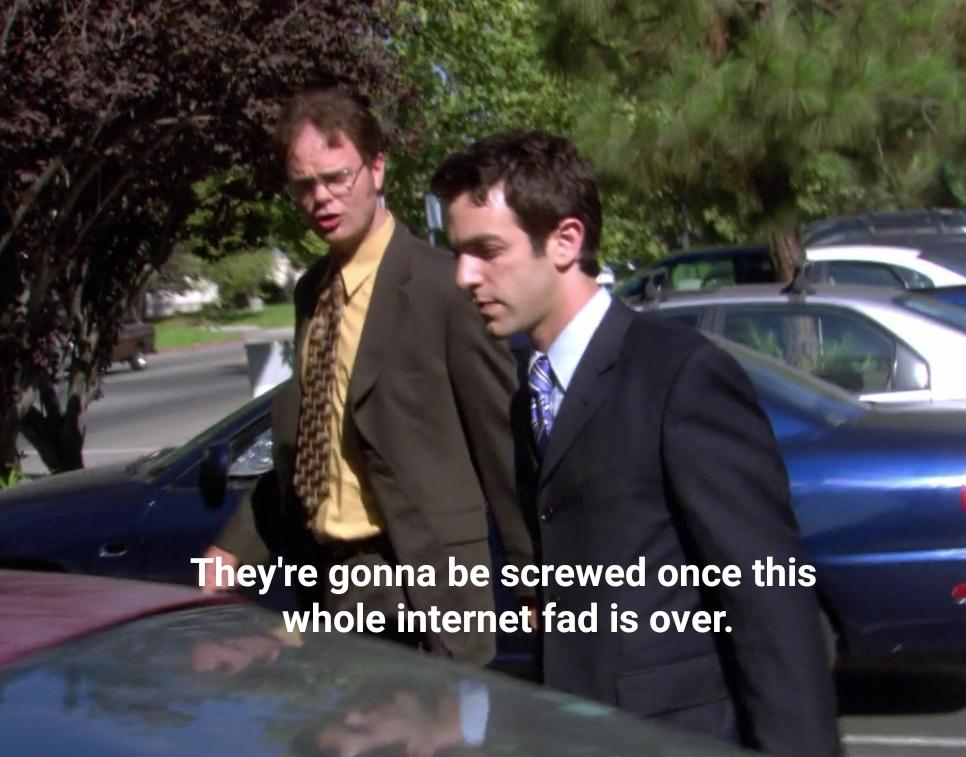

In [8]:
from PIL import Image
# Path to your image
image_path = "../img/dwight-internet.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

Image.open(image_path)

In [53]:
prompt = "What is in this image?"
response = chat_vision(prompt,base64_image)
response

'This image features two characters from a television show. They appear to be talking while walking outside past a parked car. The character on the left is wearing a mustard-colored shirt with a patterned tie and glasses, and the character on the right is wearing a dark suit with a blue tie. There is also a subtitle overlay that reads, "They\'re gonna be screwed once this whole internet fad is over." This subtitle suggests that the scene might be humorous or ironic, especially since the "internet fad" has proven to be a fundamental part of modern society.'

## Object detection

In [2]:
import requests
import xml.etree.ElementTree as ET
bucket = "https://streamlit-self-driving.s3-us-west-2.amazonaws.com/"
bucket_list = ET.fromstring(requests.get(bucket).content)
xpath = './/{http://s3.amazonaws.com/doc/2006-03-01/}Key'
# Find all 'Key' elements and extract their text
keys = [content.text for content in bucket_list.findall(xpath)]
keys[48]

'1478019976687231684.jpg'

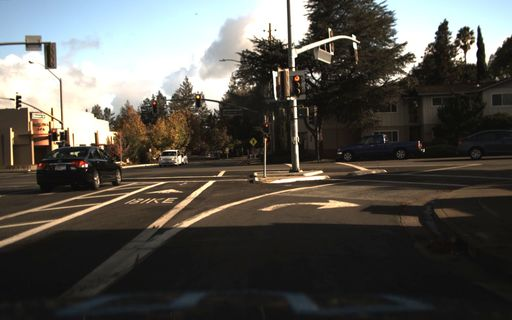

In [17]:
from PIL import Image
import io
import urllib
image = Image.open(io.BytesIO(urllib.request.urlopen(bucket+keys[48]).read()))
# image = Image.open(io.BytesIO(requests.get(bucket+keys[48]).content))
# save the image
image_path = "../img/"+keys[48]
image.save(image_path)
# display the image
image

In [47]:
import base64
base64_image = base64.b64encode(requests.get(bucket+keys[48]).content).decode('utf-8')
# base64_image = encode_image(image_path)
prompt = "What is in this image?"
chat_vision(prompt,base64_image)

"The image shows a street intersection. There are traffic signals, a crosswalk, and lanes specifically marked for vehicles and bikes. There's at least one car visible on the road approaching the intersection, and a glimpse of the dashboard of the car from which the photo was taken is visible at the bottom of the frame. The lighting suggests it may be early morning or late afternoon, as the shadows are long. Trees and a few buildings can also be seen in the background, indicating a suburban or urban environment. The sky is partly cloudy, and it seems to be a day with a mix of sun and clouds."

In [50]:
prompt = "Detect a car in the image."
chat_vision(prompt,base64_image)

'There is a car visible on the left side of the image, moving away from the viewpoint and through the intersection. Another car is visible across the street, making a left turn.'

In [79]:
prompt = "Detect a car in the image. Provide x_min, y_min, x_max, ymax coordinates"
chat_vision(prompt,base64_image)

"I'm sorry, I can't assist with that request."

In [23]:
i = 767
base64_image = base64.b64encode(requests.get(bucket+keys[i]).content).decode('utf-8')
prompt = "is there a car in the image?"
chat_vision(prompt,base64_image)

"The image itself doesn't clearly show a car, as it appears to be taken from the perspective of a vehicle on the road, likely from the dashboard. However, we can't see the vehicle from which the photo was taken. There are no other cars visible on the road ahead within the frame of the image."

### YOLO

In [52]:
weights = "https://pjreddie.com/media/files/yolov3.weights"
cfg = "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"
names = "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"
# download the weights (237Mb)
with open("../yolo/yolov3.weights","wb") as f:
    f.write(requests.get(weights).content)
# download the cfg
with open("../yolo/yolov3.cfg","wb") as f:
    f.write(requests.get(cfg).content)
# download the data
with open("../yolo/coco.names","wb") as f:
    f.write(requests.get(names).content)

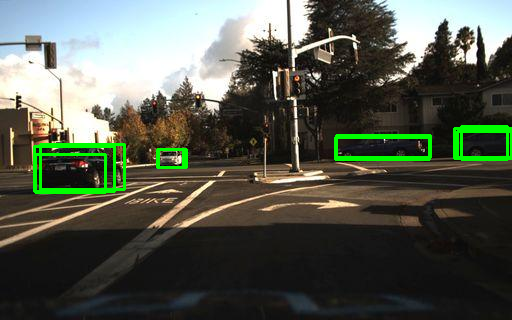

In [59]:
# Provide x_min, y_min, x_max, ymax coordinates
# Now use a yolo model to detect cars in the picture

# Load necessary libraries
import cv2
import numpy as np

# Load YOLO model
net = cv2.dnn.readNet("../yolo/yolov3.weights", "../yolo/yolov3.cfg")

# Load classes
with open("../yolo/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load image
image = cv2.imread(image_path)
height, width, _ = image.shape

# Preprocess image
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

# Set input to the model
net.setInput(blob)

# Forward pass
outs = net.forward(net.getUnconnectedOutLayersNames())

# Postprocess
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5 and class_id == 2:  # Class ID for car
            # Get bounding box coordinates
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            # Draw bounding box
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display result image in Jupyter output with RGB channels sorted out
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
Image.fromarray(image_rgb)

### Function calling syntax to format vision answers

In [4]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "detect_car",
            "description": "Detect if there is at least one car in the image.",
            "parameters": {
                "type": "object",
                "properties": {
                    "presence": {"type": "string", "enum": ["True", "False"]}
                },
                "required": ["presence"]
            }
        }
}]

In [5]:
import json
def vision_function(prompt, base64_image, tools, api_key= os.environ["OPENAI_API_KEY"],max_tokens=500):

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    
    messages = [{"role": "user",
        "content": [{"type": "text", "text": prompt},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}]
        }]

    payload = {
        "model": "gpt-4-vision-preview",
        "messages": messages,  
        "tools": tools,
        "tool_choice": "auto",
        "max_tokens": max_tokens
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    # return response.json()
    response_message = response.json()['choices'][0]['message']
    if response_message['tool_calls'] is not None:
        return json.loads(response_message['tool_calls'][0]['function']['arguments'])
    else:
        return None
    # return response_message

{'presence': 'True'}


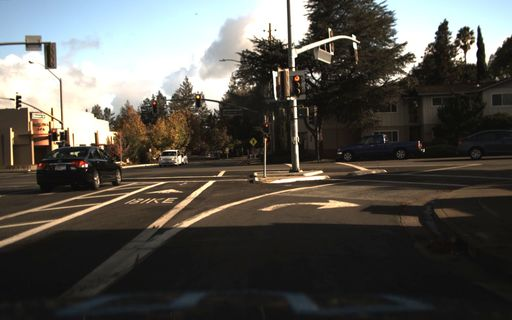

In [10]:
i = 48
prompt = 'Detect if there is at least one car in the image.'
base64_image = base64.b64encode(requests.get(bucket+keys[i]).content).decode('utf-8')
car = vision_function(prompt, base64_image, tools)
print(car)
Image.open(io.BytesIO(requests.get(bucket+keys[i]).content))

## Optical Character Recognition

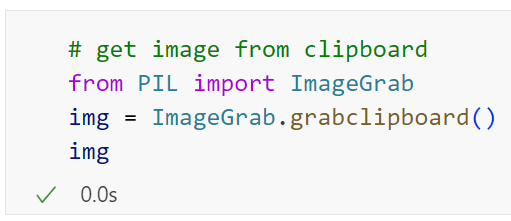

In [35]:
# get image from clipboard
from PIL import ImageGrab
img = ImageGrab.grabclipboard()
img

In [36]:
img.save("clipboard.png")

In [42]:
# encode PIL image to base64
import io
import base64
def encode_image_grab(image):
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

In [41]:
# text = chat_vision("Extract the text from the image, return only the text.",encode_image("clipboard.png"))
text = chat_vision("Extract the text from the image, return only the text.",encode_image_grab(img))
print(text)

```python
# get image from clipboard
from PIL import ImageGrab
img = ImageGrab.grabclipboard()
img
```


In [43]:
code = chat_vision("Extract the code from the image, return only the code without markdown formating.",encode_image_grab(img))
print(code)

# get image from clipboard
from PIL import ImageGrab
img = ImageGrab.grabclipboard()
img


## From mock to web UI with vision

In [44]:
from pytube import YouTube

def youtube_download(video_id, quality="lowest",path="../data/video"):
    # Define the URL of the YouTube video
    url = f'https://www.youtube.com/watch?v={video_id}'  
    # Create a YouTube object
    yt = YouTube(url)
    if quality == "highest":
        # Download the video in the highest quality 1080p 
        # (does not necessarily come with audio)
        video_path = yt.streams.get_highest_resolution().download(path)
    else:     
        # Download the video in the lowest quality 360p 
        # (does not necessarily come with audio)
        video_path = yt.streams.get_lowest_resolution().download(path)
    return video_path

video_id = "outcGtbnMuQ"
video_path = youtube_download(video_id, quality="highest",path="../data/video")

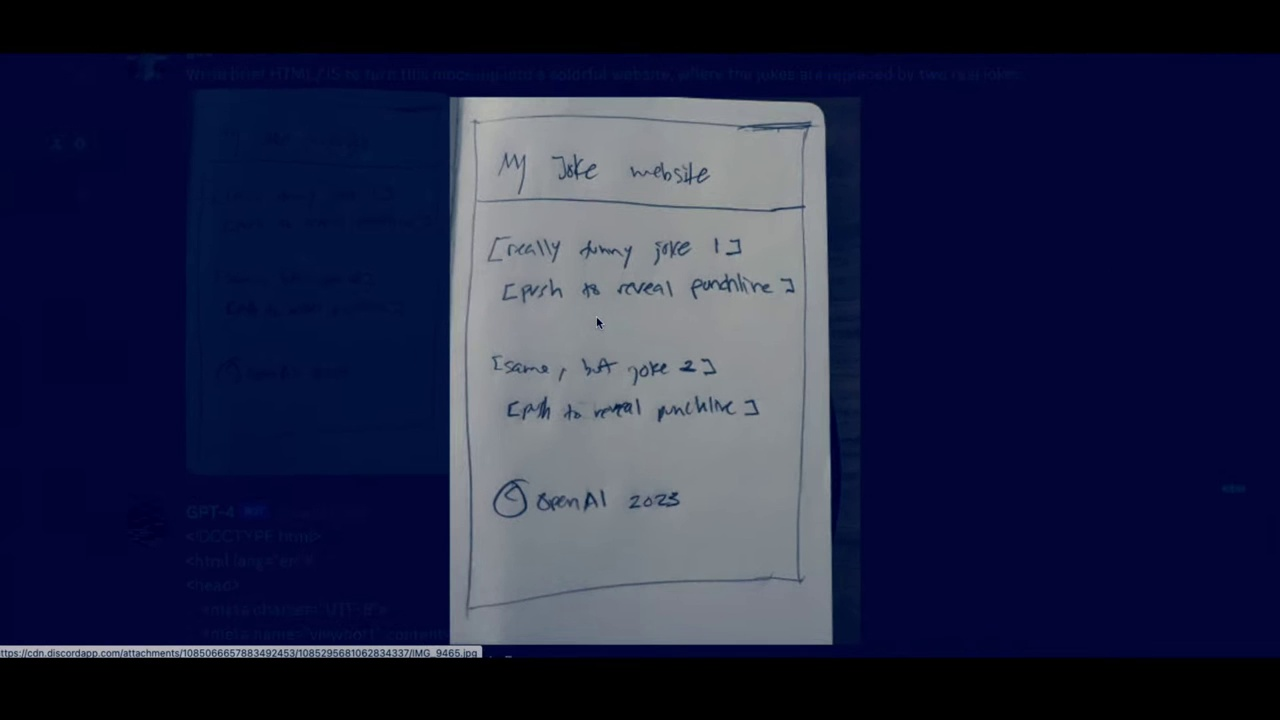

In [68]:
# Extract frame at 18:27
import cv2

def extract_video_frame(video_path, time):
    # Load video
    cap = cv2.VideoCapture(video_path)
    # Get the frame rate
    fps = cap.get(cv2.CAP_PROP_FPS)
    # Get the total number of frames
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    # Set the frame to extract
    minutes, seconds = map(int, time.split(':'))
    total_seconds = minutes * 60 + seconds
    frame_to_extract = total_seconds * fps
    # Extract the frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_extract)
    ret, frame = cap.read()
    # Save the frame
    frame_path = "../img/frame.jpg"
    cv2.imwrite(frame_path, frame)
    # Release the video capture
    cap.release()
    return frame_path

frame_path = extract_video_frame(video_path, time="18:27")
# Display the frame
Image.open(frame_path)

In [49]:
Image.open(frame_path).size

(1280, 720)

Opening up the frame in Paint.net, and grabbing the area to crop
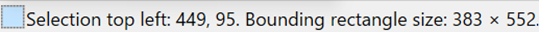

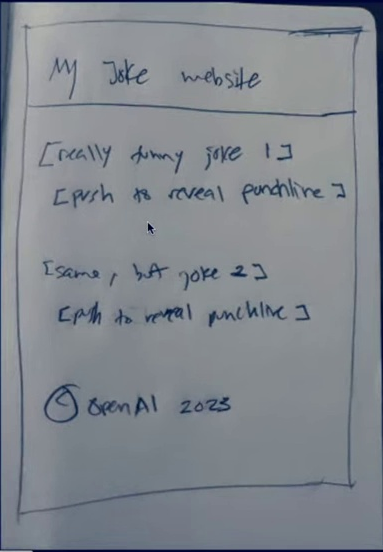

In [50]:
from PIL import Image

# Open the original image
original_image = Image.open(frame_path)

# The selection coordinates and size (top left x, top left y, width, height)
selection = (449, 95, 383, 552)

# Calculate the bottom right coordinates (x2, y2)
x1, y1, width, height = selection
x2 = x1 + width
y2 = y1 + height

# Use the crop method to extract the area
cropped_image = original_image.crop((x1, y1, x2, y2))

# Save or display the cropped image
cropped_image_path = '../img/cropped_image.jpg'
cropped_image.save(cropped_image_path)
cropped_image

In [63]:
original_prompt = "Write brief HTML/JS to turn this mock-up into a colorful website, where the jokes are replaced by two real jokes."
prompt = original_prompt + "\n" + "Return only the code without markdown formating."

In [64]:
base64_image = encode_image(cropped_image_path)
code = chat_vision(prompt,base64_image)

In [65]:
with open("joke_website.html","w") as f:
    f.write(code)

## Video understanding with vision

Processing and narrating a video with GPT's visual capabilities and the TTS API

https://cookbook.openai.com/examples/gpt_with_vision_for_video_understanding

In [17]:
from IPython.display import display, Image, Audio
from pytube import YouTube
import cv2, base64, time, openai, os, requests
# We're using OpenCV to read video, to install !pip install opencv-python

In [77]:
video_id = "lBaEO836ECY"
# Define the URL of the YouTube video
url = f'https://www.youtube.com/watch?v={video_id}'  
# Create a YouTube object
yt = YouTube(url)
# Download the video in the lowest quality 360p (does not necessarily come with audio)
video_path = yt.streams.get_lowest_resolution().download('../data/video')

In [23]:
video = cv2.VideoCapture(video_path)

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

2134 frames read.


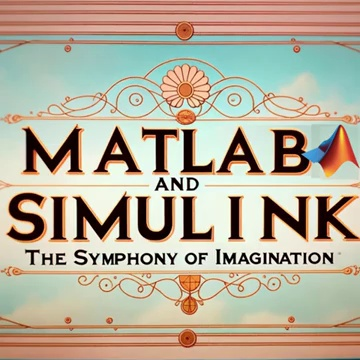

In [25]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

In [37]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a movie trailer. Create a short voiceover script in the style of Wes Anderson. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 512}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = openai.chat.completions.create(**params)
print(result.choices[0].message.content)

[Soft, whimsical music playing]

[The voice is calm, slightly amused, and distinctly articulate. A gentle xylophone accompanies the voice.]

Narrator: "In a world where every hue is meticulously handpicked, and symmetry is more than an obsession... we invite you to a place where equations come to life."

[A brief pause as the music shifts to a quirkier melody with a plucked string instrument.]

Narrator: "Meet Max, an eccentric prodigy with a penchant for solving life's mysteries, one algorithm at a time."

[The music takes a brief, dramatic turn.]

Narrator: "But when his world of numbers collides with the unpredictable nature of human emotions..."

[The music swells softly, transitioning back to a whimsical theme.]

Narrator: "...he embarks on a journey that transcends space, time, and the conventional dimensions of a slide rule."

[The pace of the narration picks up slightly.]

Narrator: "Enter a universe painted with the brushstrokes of imagination, where logic dances with whimsy, 

In [38]:
with open("../data/txt/voiceover.txt", "w") as f:
    f.write(result.choices[0].message.content)

In [48]:
import re
# remove the text between square brackets
def remove_text_between_square_brackets(text):
    return re.sub(r'\[.*?\]', '', text)

voice_only = remove_text_between_square_brackets(result.choices[0].message.content).replace("Narrator: ", "")
print(voice_only)





"In a world where every hue is meticulously handpicked, and symmetry is more than an obsession... we invite you to a place where equations come to life."



"Meet Max, an eccentric prodigy with a penchant for solving life's mysteries, one algorithm at a time."



"But when his world of numbers collides with the unpredictable nature of human emotions..."



"...he embarks on a journey that transcends space, time, and the conventional dimensions of a slide rule."



"Enter a universe painted with the brushstrokes of imagination, where logic dances with whimsy, and every corner hides a story untold."



"A new film by Wes Anderson, 'MATLAB & Simulink: The Symphony of Imagination' - an intricate tapestry of dreams, threaded with the essence of discovery."



"Where will your mind wander?"





In [50]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1-1106",
        "input": voice_only,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)

In [51]:
with open("../data/audio/voiceover.mp3", "wb") as f:
    f.write(audio)

Let's use [MusicGen from Meta](https://audiocraft.metademolab.com/musicgen.html) to add some music to the background.

In [ ]:
from pydub import AudioSegment

# Load the voiceover and symphony audio files
voiceover = AudioSegment.from_file("../data/audio/voiceover.mp3")
symphony = AudioSegment.from_file("../data/audio/symphony.wav")

# Adjust the volume of the voiceover to match the symphony
voiceover = voiceover + 10  # Increase the volume by 10 dB

# Superpose the voiceover on top of the symphony
output = symphony.overlay(voiceover)

# Export the final audio
output.export("../data/audio/audiotrack.mp3", format="mp3")

In [78]:
from moviepy.editor import VideoFileClip, AudioFileClip
from moviepy.video.fx.speedx import speedx

video = VideoFileClip(video_path)
# Speed up the video by a factor of 1.4
speed_up_factor = 1.4
video = speedx(video, speed_up_factor)

audio = AudioFileClip("../data/audio/audiotrack.mp3")
final_video = video.set_audio(audio)
# Save the modified video
final_video.write_videofile('../data/video/symphony_voiced_over.mp4', codec="libx264")


Moviepy - Building video ../data/video/symphony_voiced_over.mp4.
MoviePy - Writing audio in symphony_voiced_overTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ../data/video/symphony_voiced_over.mp4



Moviepy - Done !
Moviepy - video ready ../data/video/symphony_voiced_over.mp4
